# Rehnquist Court Analysis MFT (6/14/2019)

## Correlation matrix

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from math import *
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
autoreload 2

In [4]:
sup_court_data = pd.read_csv("SCDB_2018_02_justiceCentered_Citation.csv",encoding = "ISO-8859-1")

is_rehnquist = ((sup_court_data['term'].astype(int) > 1994) & (sup_court_data['term'].astype(int) < 2005))
rehnquist_data = sup_court_data[is_rehnquist]

In [5]:
justices = ['JPStevens',
            'RBGinsburg',
            'DHSouter',
            'SGBreyer',
            'SDOConnor',
            'AMKennedy',
            'WHRehnquist',
            'AScalia',
            'CThomas']

In [6]:
to_ising = lambda x: 2 * (x - 1.0) - 1.0
voting_data = rehnquist_data.pivot(columns="justiceName", index="caseId", values="direction")
voting_data = voting_data[justices]
voting_data = voting_data.transform(to_ising)
voting_data = voting_data.dropna(0)

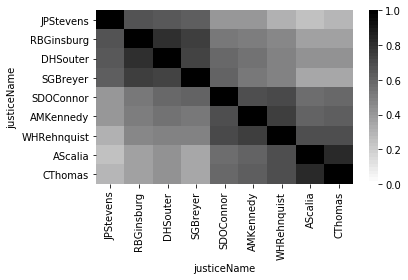

In [7]:
corr = voting_data.corr()
gs = sns.cubehelix_palette(50, hue=0.01, rot=0, light=1.0, dark=0.0)
sns.heatmap(corr, cmap=gs, xticklabels=corr.columns, yticklabels=corr.columns,  vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("../../writeups/correlations.png")
np.savetxt("scotus_correlation.csv", corr, delimiter=',')

## Extracting $J_{ij}$ using Mean Field Theory

Note that this paper is super helpful: https://arxiv.org/pdf/1601.03449.pdf

1) Just sample once lol

2) Make sure that you're getting the right initial answer.

In [8]:
import itertools
import scipy
from scipy.optimize import minimize
from copy import copy

In [9]:
# Determines p_i and p_{ij} vectors, denoted as pvec and pbin

pvec = np.sum((voting_data+1.0)/2) / len(voting_data)
pbin = np.zeros((9,9))
voting_data_qubo = np.array(np.transpose((voting_data + 1.0)/2))
for i in range(9):
    for j in range(9):
        bin_occ = voting_data_qubo[i] * voting_data_qubo[j]
        pbin[i][j] = np.average(bin_occ)

N = 9
C = voting_data.corr()


J_diag_factor = np.array([[(((pbin[i][j] - pvec[i]*pvec[j]) * (pvec[i] - 0.5))/(pvec[i] * (1-pvec[i])))\
                           - pvec[j] for j in range(N)] for i in range(N)])

In [127]:
ceig = scipy.linalg.eig(C)
cvals, cvecs = ceig
cvals = np.real(cvals)
V = cvecs
Vinv = np.transpose(cvecs)

def get_analytic_J(gamma):
    """ Returns the analytic solution for Jij given a gamma tuning term """
    jvals = [np.power(0.5 * (cq - gamma + sqrt((cq - gamma)**2 + 4 * gamma)), -1) for cq in cvals]
    J_prime = V@np.diag(jvals)@Vinv
    J = np.zeros((9,9))
    return(J_prime)

    factor = 0
    for i in range(N):
        for j in range(i+1, N):
            factor = sqrt(pvec[i] * (1-pvec[i]) * pvec[j] * (1-pvec[j]))
            J[i][j] = J_prime[i][j] / factor
            J[j][i] = J_prime[j][i] / factor
    # Ignoring the below lines of code automatically sets the diagonal to 0. That isn't 
    # what the paper says it eh correct analytic solution, but I think it's reasonable since we
    # know that's what the correct answer should in general be.
    """
    for i in range(N):
        diag_elem = 0.0
        for j in range(N):
            if i != j: diag_elem += J[i][j] * ((pbin[i][j] - pvec[i] * pvec[j]) * (pvec[i] - 0.5) / 
                                              (pvec[i] * (1-pvec[i])) - pvec[j])
            J[i][i] = diag_elem
    """
    return(J)

In [11]:
def ising_log_likelihood(state, J):
    return(-state@J@state)

def mft_log_likelihood(J, gamma):
    mft_term = 0.0
    for i in range(N):
        for j in range(i+1, N):
            mft_term += (J[i][j] * J[i][j]) * pvec[i] * (1-pvec[i]) * pvec[j] * (1-pvec[j])
    return(gamma * mft_term)

def total_log_likelihood(state, J, gamma):
    return(ising_log_likelihood(state, J) + mft_log_likelihood(state, J, gamma))

In [12]:
def fast_sample(gamma, start_state, J, num_samples = 100):
    """ Returns num_samples samples. Makes two main adjustments
    1) Don't recalculate the MFT energy factor, just add it on at the end.
    2) Only calculate differences in energy
    """
    state_list = [start_state]
    old_E = ising_log_likelihood(start_state, J)
    energies = [old_E]
    
    while len(state_list) < num_samples:
        new_state = copy(state_list[-1])
        k = np.random.choice(range(N))

        # The below line is ONLY valid if J[k][k] = 0! Importantly, this is not what the cited paper 
        # does, but we know that we should be able to throw out quadratic terms. 
        dE = 4 * new_state[k] * (J[k] @ new_state)
        accept = (np.exp(-dE) > np.random.rand())
        if accept:
            new_state[k] *= -1
            state_list.append(new_state)
            energies.append(energies[-1] + dE)
    
    energies += mft_log_likelihood(J, gamma)
    return([energies, state_list])

In [19]:
J = np.loadtxt("jij_sols.csv", delimiter=',')

## EVERYHING BELOW IS NOT OPTIMIZED

In [20]:
def my_chi_squared(gamma):
    J = get_analytic_J(gamma)
   # start_state = np.random.choice([-1,1], size = N)
    start_state = np.array([ 1, -1 ,-1,  1 , 1, -1,  1, -1,  1])
    print(start_state)
    probs, all_states = fast.cfast_sample(gamma, start_state, J, 
                        num_samples = 1000)
    print("done")
    num_data_pts = 810
    return(0)
    chi = 0.0
    all_states_transpose = np.transpose((all_states + 1.0) / 2.0)
    for i in range(N):
        for j in range(i, N):
            err = pbin[i][j] * (1-pbin[i][j]) / num_data_pts
            pij_model = all_states_transpose[i] * all_states_transpose[j] * probs
            chi += (2 / (9 * 10)) * ((pbin[i][j] - pij_model) ** 2) / err
    return(chi)

In [ ]:
def plot_heatmap(J):
    J_ = deepcopy(J)
    if J_.shape != (9,9): J_ = J_.reshape((9,9))
    cm = sns.diverging_palette(248, 12, sep=1, n=256)
    sns.heatmap(J_, cmap=cm, xticklabels=justices, yticklabels=justices,  vmin=-1, vmax=1)